In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.optimize import curve_fit
from utils.functions import PiecewiseLinear

In [2]:
data_path = os.path.dirname(os.path.abspath("")) + '/analysis/plant_data/first_exp_area_over_time.csv'
df = pd.read_csv(data_path).sort_values(by='timestamp')
df['timestamp'] = pd.to_datetime(df['timestamp'])

sub_df0 = df[df['timestamp'].dt.date.isin([
    pd.Timestamp('2025-02-26').date(),
    pd.Timestamp('2025-02-27').date(),
    pd.Timestamp('2025-02-28').date()
])]

sub_df1 = df[df['timestamp'].dt.date.isin([
    pd.Timestamp('2025-03-01').date(),
    pd.Timestamp('2025-03-02').date(),
    pd.Timestamp('2025-03-03').date()
])]

In [3]:
# Number of time steps per day
sub_df0['timestamp'] = pd.to_datetime(sub_df0['timestamp'])
timestamps_per_day = sub_df0['timestamp'].dt.date.value_counts()
if timestamps_per_day.nunique() != 1:
    raise ValueError(f"Inconsistent timestamps per day: {timestamps_per_day.to_dict()}")
steps_per_day = timestamps_per_day.iloc[0]
print(f'steps_per_day={steps_per_day}')

# Number of time steps per night
time_increment = sub_df0['timestamp'].diff().mode()[0]
night_duration = df.groupby(sub_df0['timestamp'].dt.date)['timestamp'].first().shift(-1) - sub_df0.groupby(sub_df0['timestamp'].dt.date)['timestamp'].last()
steps_per_night = int((night_duration.mode()[0] / time_increment)-1)
print(f'steps_per_night={steps_per_night}')

steps_per_day=144
steps_per_night=144


/tmp/ipykernel_24422/2143248305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df0['timestamp'] = pd.to_datetime(sub_df0['timestamp'])


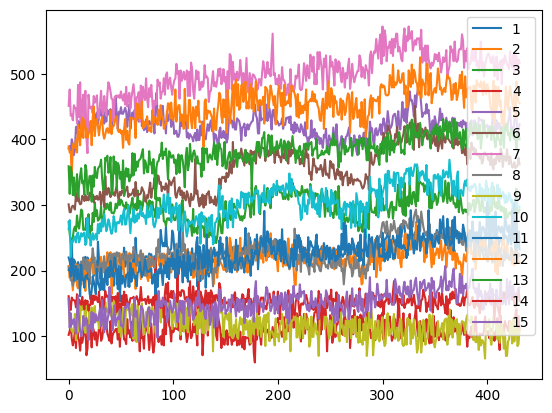

In [4]:
area0 = np.array(sub_df0.drop(columns=['timestamp']))
for i in range(16):
    if i != 0:   # plant #0's data looks anomalous
        plt.plot(area0[:,i], label = i)
plt.legend()

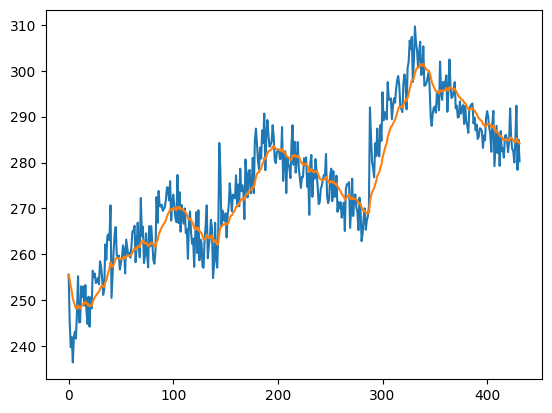

In [5]:
# Averaging all 16 plants
ave_area0 = np.mean(area0[:,1:], axis=1)

# Smoothing
def moving_average(x, trace_decay_rate = 0.9):
    smooth_x = [x[0]]
    for i in range(1, len(x)):
        smooth_x.append(trace_decay_rate * smooth_x[-1] + (1-trace_decay_rate)*x[i])
    return np.array(smooth_x)
smooth_ave_area0 = moving_average(ave_area0)
plt.plot(ave_area0)
plt.plot(smooth_ave_area0)

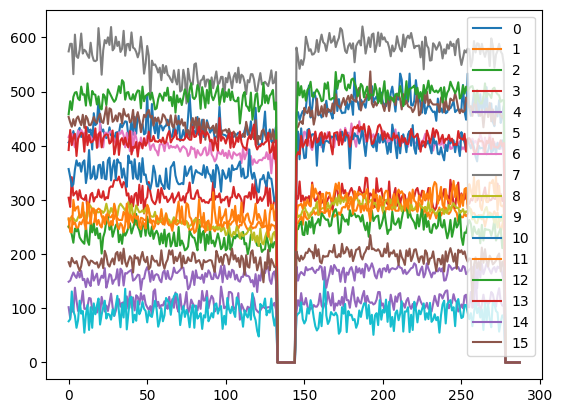

In [6]:
area1 = np.array(sub_df1.drop(columns=['timestamp']))[:steps_per_day*2,:]
for i in range(16):
    plt.plot(area1[:,i], label = i)
plt.legend()

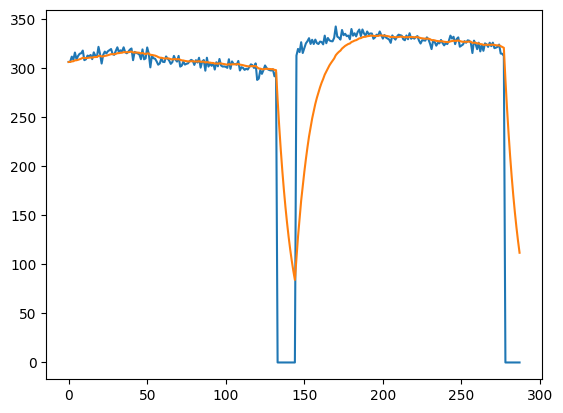

In [7]:
# Averaging all 16 plants
ave_area1 = np.mean(area1[:,:], axis=1)

# Remove the last hour where all areas are zeros
#ave_area1 = ave_area1[np.nonzero(ave_area1)]

# Smoothing
def moving_average(x, trace_decay_rate = 0.9):
    smooth_x = [x[0]]
    for i in range(1, len(x)):
        smooth_x.append(trace_decay_rate * smooth_x[-1] + (1-trace_decay_rate)*x[i])
    return np.array(smooth_x)
smooth_ave_area1 = moving_average(ave_area1)
plt.plot(ave_area1)
plt.plot(smooth_ave_area1)

In [8]:
ave_area = np.hstack([ave_area0, ave_area1])

best fit power law ~ x^1.01


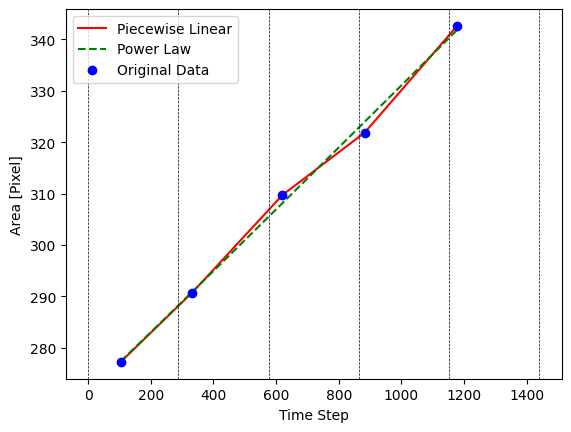

In [9]:
observed_area = np.reshape(ave_area, (-1, steps_per_day))  # reshape into different days
max_indices = np.argmax(observed_area, axis=1)         # index at the max value of each day

max_time = []
max_area = []
for i in range(observed_area.shape[0]):
    max_time.append(i*(steps_per_day+steps_per_night) + max_indices[i])
    max_area.append(ave_area[i*steps_per_day + max_indices[i]])

popt, pcov = curve_fit(lambda x, a, b, c: a * np.power(x, b) + c, max_time, max_area)
pwl = PiecewiseLinear(max_time, max_area)

x_values = np.linspace(max_time[0], max_time[-1], 1000) 
y_power = popt[0] * np.power(x_values, popt[1]) + popt[2]
print(f'best fit power law ~ x^{popt[1]:.2f}')
y_linear = [pwl(x) for x in x_values]

# Plot
plt.plot(x_values, y_linear, 'r-', label='Piecewise Linear')
plt.plot(x_values, y_power, 'g--', label='Power Law')
plt.plot(max_time, max_area, 'bo', label='Original Data') 
for i in range(int(len(ave_area)/steps_per_day)+1):
    plt.axvline(x = (steps_per_day+steps_per_night)*i, color='k', linestyle='--', linewidth=0.5)
plt.xlabel('Time Step')
plt.ylabel('Area [Pixel]')
plt.legend()
plt.show()

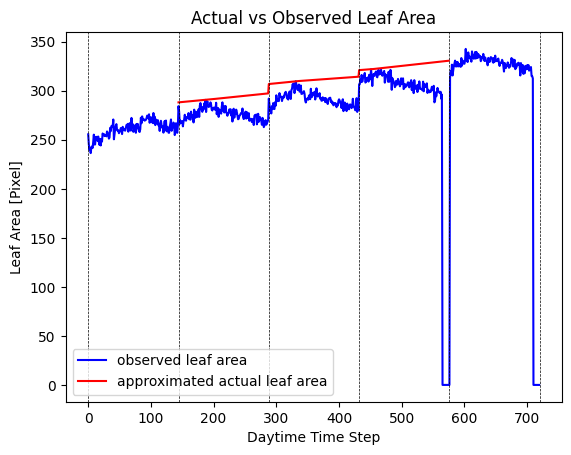

In [10]:
# Compute an array of actual area during daytime
actual_area_power = []
actual_area_linear = []
for i in range(1, observed_area.shape[0]-1):
    t0 = i*(steps_per_day + steps_per_night)
    t1 = t0 + steps_per_day
    x_values = np.arange(t0, t1)
    y_power_values = popt[0] * np.power(x_values, popt[1]) + popt[2]
    y_linear_values = [pwl(x) for x in x_values]
    actual_area_power.append(y_power_values)
    actual_area_linear.append(y_linear_values)
actual_area_power = np.hstack(actual_area_power)
actual_area_linear = np.hstack(actual_area_linear)

# Plot the actual vs observed area
plt.plot(np.arange(0, 5*steps_per_day), observed_area.reshape(-1), 'b', label='observed leaf area')
plt.plot(np.arange(steps_per_day, 4*steps_per_day), actual_area_linear, 'r', label='approximated actual leaf area')
for i in range(int(len(ave_area)/steps_per_day)+1):
    plt.axvline(x = (steps_per_day)*i, color='k', linestyle='--', linewidth=0.5)
plt.title(f'Actual vs Observed Leaf Area')
plt.xlabel('Daytime Time Step')
plt.ylabel('Leaf Area [Pixel]')
plt.legend()
plt.show()

(0.0, 432.0)

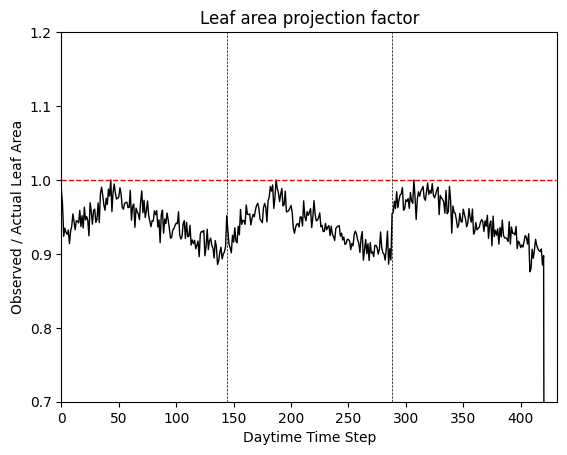

In [11]:
truncated_data = ave_area[steps_per_day:-steps_per_day]
projection_factor = truncated_data/actual_area_linear

plt.plot(projection_factor, 'k', linewidth=1)
plt.plot(np.arange(len(projection_factor)), np.ones(len(projection_factor)), 'r--', linewidth=1)
for i in range(int(len(ave_area)/steps_per_day)-1):
    plt.axvline(x = (steps_per_day)*i, color='k', linestyle='--', linewidth=0.5)
plt.title('Leaf area projection factor')
plt.xlabel(f'Daytime Time Step')
plt.ylabel(f'Observed / Actual Leaf Area')
plt.ylim(0.7,1.2)
plt.xlim(0,len(projection_factor))